## My public kernel: https://www.kaggle.com/podsyp/titanic-starter-eda-tsne-kfold-lgb

This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Read on or watch the video below to explore more details. Once you’re ready to start competing, click on the "Join Competition button to create an account and gain access to the competition data. Then check out Alexis Cook’s Titanic Tutorial that walks you through step by step how to make your first submission!

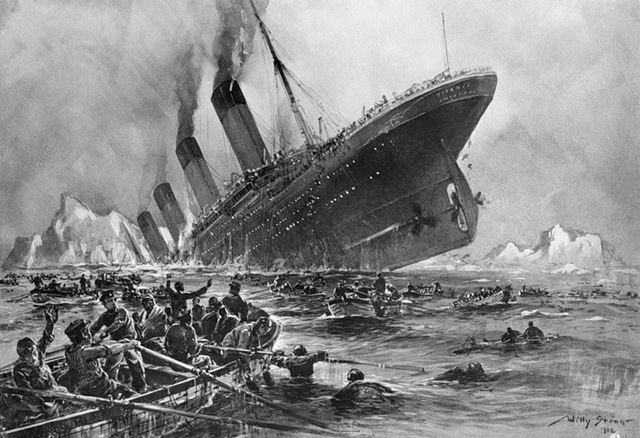

# The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## What Data Will I Use in This Competition?
In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.

## Goal
It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, you must predict a 0 or 1 value for the variable.

## Metric
Your score is the percentage of passengers you correctly predict. This is known as accuracy.

# Import some libs

In [79]:
import numpy as np 
import pandas as pd 
import pandas_summary as ps
from category_encoders import WOEEncoder

In [80]:
# Lgbm
import lightgbm as lgb

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

# Hyper_opt
from hyperopt import hp
from hyperopt import fmin, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
import hyperopt.pyll
from hyperopt.pyll import scope

# Suppr warning
import warnings
warnings.filterwarnings("ignore")

# Plots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

# Others
import shap

# Load Datasets

In [81]:
folder = 'data/'
train_df = pd.read_csv(folder + 'train.csv')
test_df = pd.read_csv(folder + 'test.csv')
sub_df = pd.read_csv(folder + 'gender_submission.csv')

In [82]:
print('train')
print('All: ', train_df.shape)
print('test')
print('All: ', test_df.shape)
print('sub')
print('sub ', sub_df.shape)

train
All:  (891, 12)
test
All:  (418, 11)
sub
sub  (418, 2)


In [83]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [84]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [85]:
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Data Set Column Descriptions
- pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- survived: Survival (0 = No; 1 = Yes)
- name: Name
- sex: Sex
- age: Age
- sibsp: Number of siblings/spouses aboard
- parch: Number of parents/children aboard
- fare: Passenger fare (British pound)
- embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- cabin:Cabin number
- ticket:Ticket number

### Binary Sex

In [86]:
train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if str(x) == 'male' else 0)
test_df['Sex'] = test_df['Sex'].apply(lambda x: 1 if str(x) == 'male' else 0)

### Drop Passenger Id

In [87]:
train_df.drop('PassengerId', axis=1, inplace=True)
test_df.drop('PassengerId', axis=1, inplace=True)

In [88]:
# Check correlation

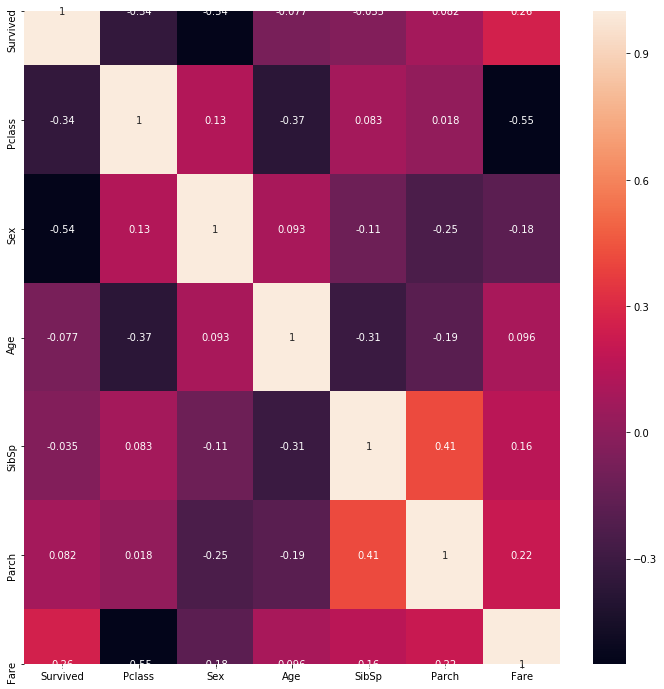

In [89]:
train_corr = train_df.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(train_corr, xticklabels=train_corr.columns, yticklabels=train_corr.columns, annot=True, ax=ax);

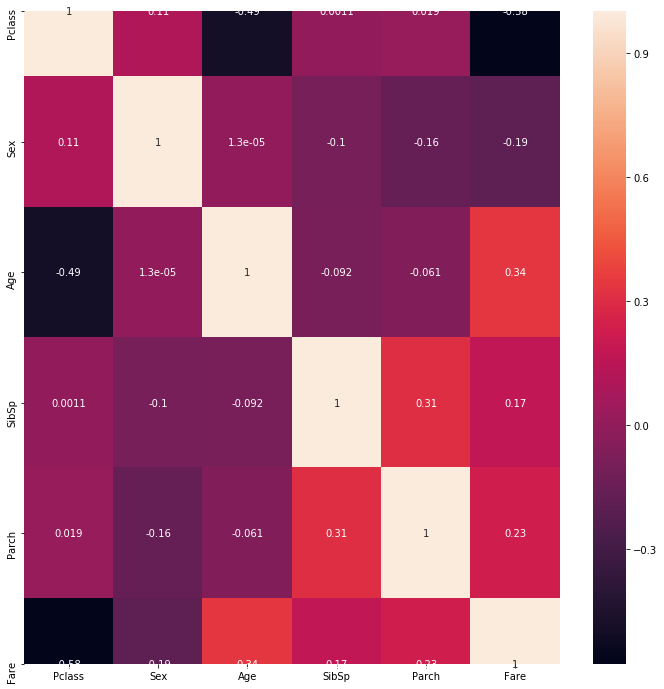

In [90]:
test_corr = test_df.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(test_corr, xticklabels=test_corr.columns, yticklabels=test_corr.columns, annot=True, ax=ax);

# Let's get target

In [91]:
y = train_df['Survived']
train_df.drop('Survived', axis=1, inplace=True)

In [92]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [93]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

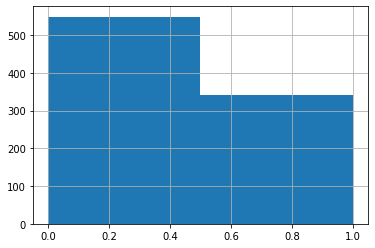

In [94]:
y.hist(bins=2);

# EDA

### Describe features

In [95]:
dfs = ps.DataFrameSummary(train_df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['Ticket', 'Cabin', 'Embarked']
numerics:  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,NaN,891,714,891,891,NaN,891,NaN,NaN
mean,2.30864,NaN,0.647587,29.6991,0.523008,0.381594,NaN,32.2042,NaN,NaN
std,0.836071,NaN,0.47799,14.5265,1.10274,0.806057,NaN,49.6934,NaN,NaN
min,1,NaN,0,0.42,0,0,NaN,0,NaN,NaN
25%,2,NaN,0,20.125,0,0,NaN,7.9104,NaN,NaN
50%,3,NaN,1,28,0,0,NaN,14.4542,NaN,NaN
75%,3,NaN,1,38,1,0,NaN,31,NaN,NaN
max,3,NaN,1,80,8,6,NaN,512.329,NaN,NaN
counts,891,891,891,714,891,891,891,891,204,889
uniques,3,891,2,88,7,7,681,248,147,3


In [96]:
dfs = ps.DataFrameSummary(test_df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['Ticket', 'Cabin', 'Embarked']
numerics:  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418,NaN,418,332,418,418,NaN,417,NaN,NaN
mean,2.26555,NaN,0.636364,30.2726,0.447368,0.392344,NaN,35.6272,NaN,NaN
std,0.841838,NaN,0.481622,14.1812,0.89676,0.981429,NaN,55.9076,NaN,NaN
min,1,NaN,0,0.17,0,0,NaN,0,NaN,NaN
25%,1,NaN,0,21,0,0,NaN,7.8958,NaN,NaN
50%,3,NaN,1,27,0,0,NaN,14.4542,NaN,NaN
75%,3,NaN,1,39,1,0,NaN,31.5,NaN,NaN
max,3,NaN,1,76,8,9,NaN,512.329,NaN,NaN
counts,418,418,418,332,418,418,418,417,91,418
uniques,3,418,2,79,7,8,363,169,76,3


## Histograms of features

for train

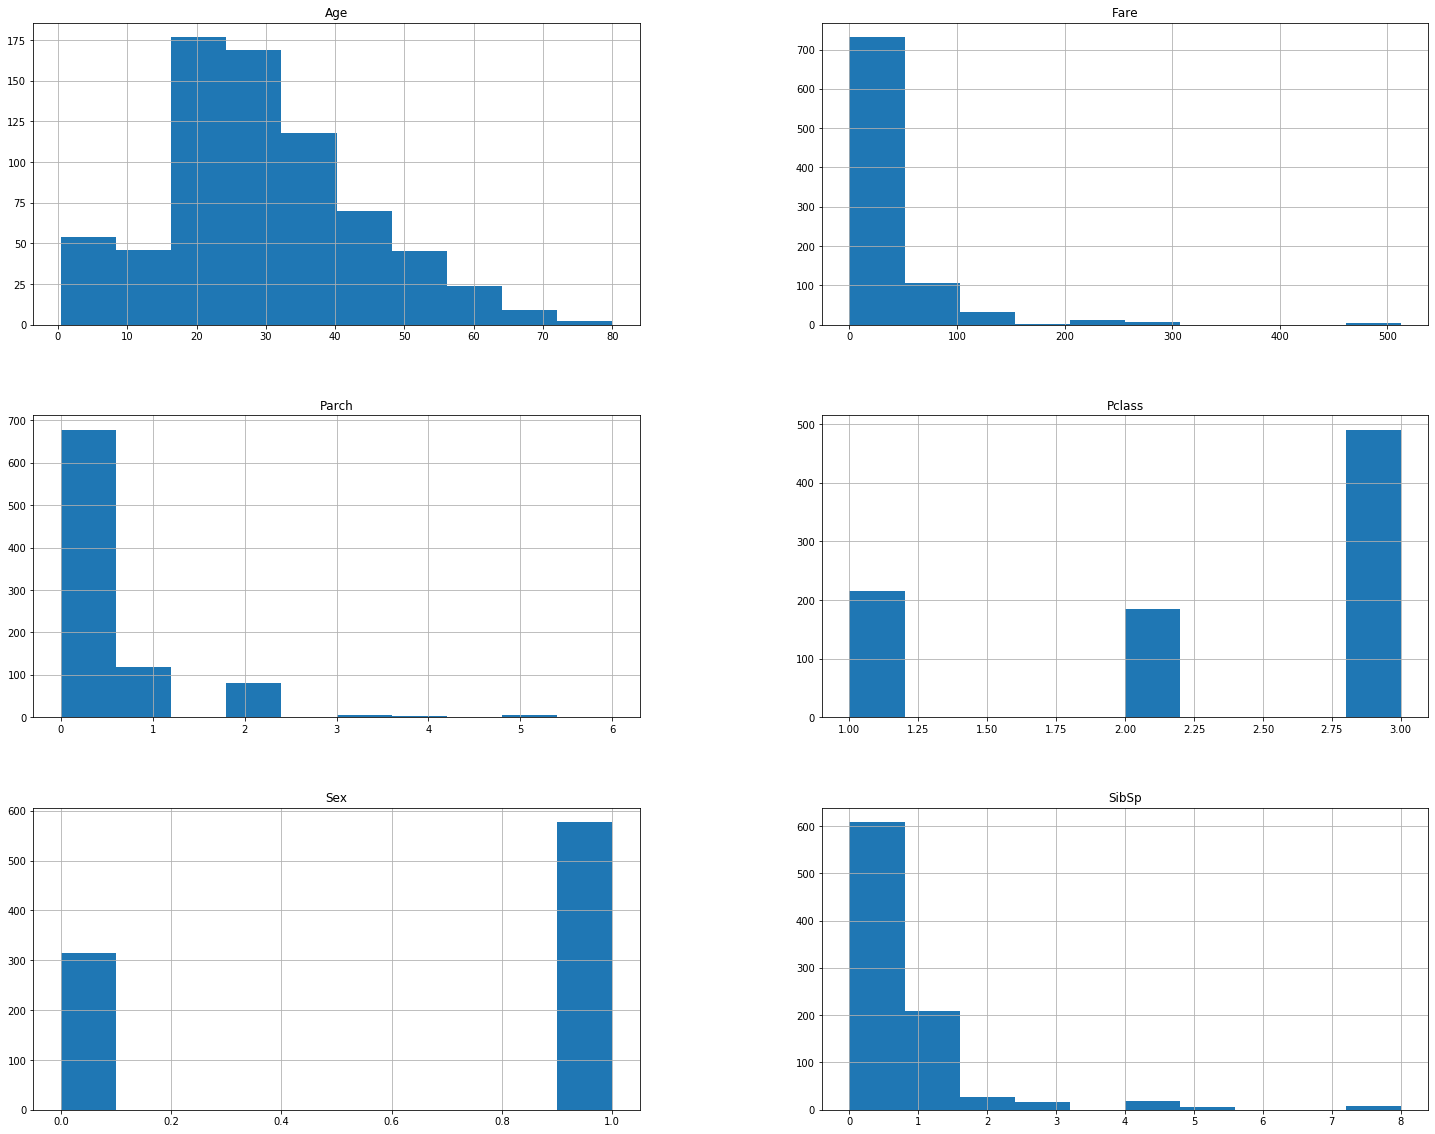

In [97]:
train_df.hist(figsize=(25, 20));

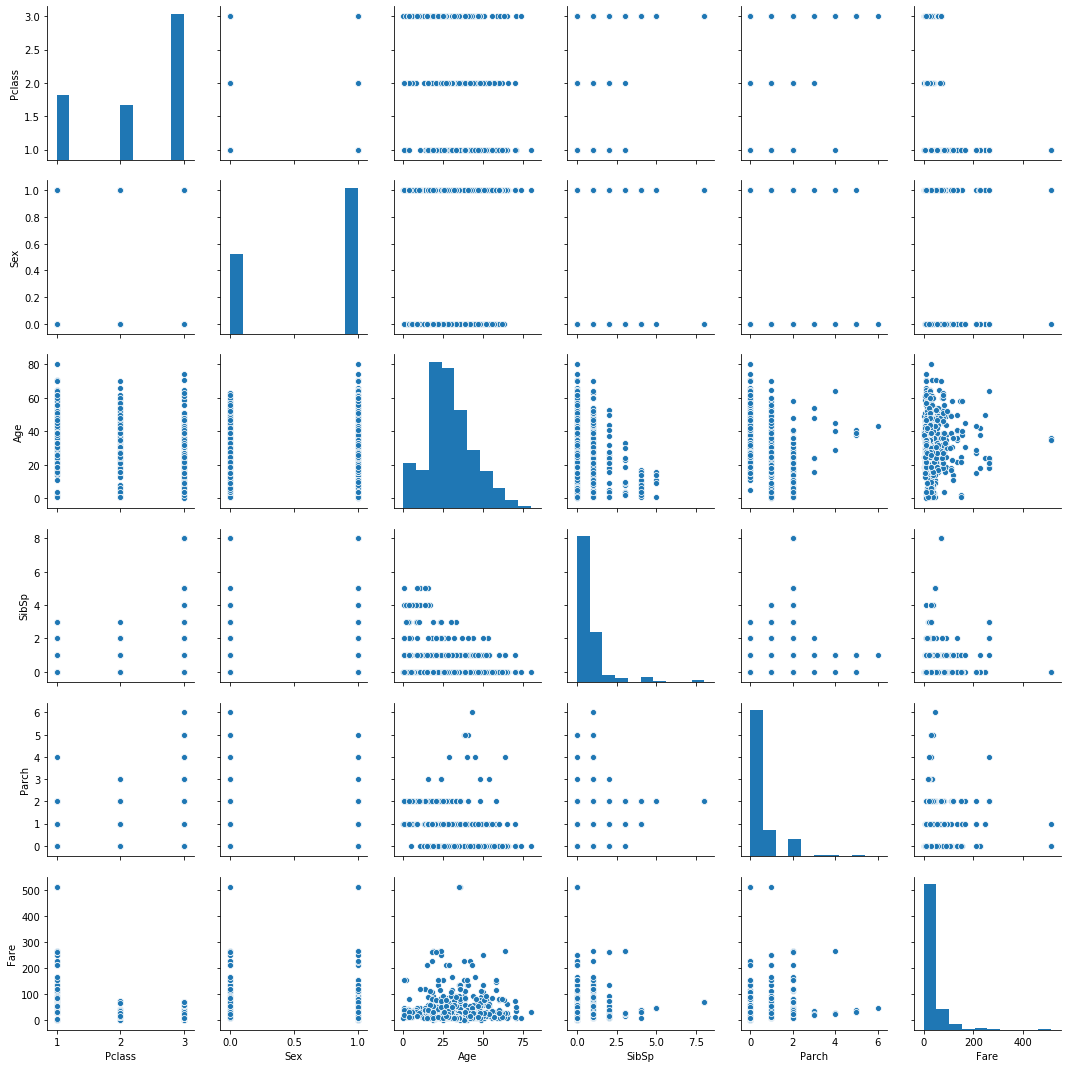

In [98]:
sns.pairplot(data=train_df);

for test

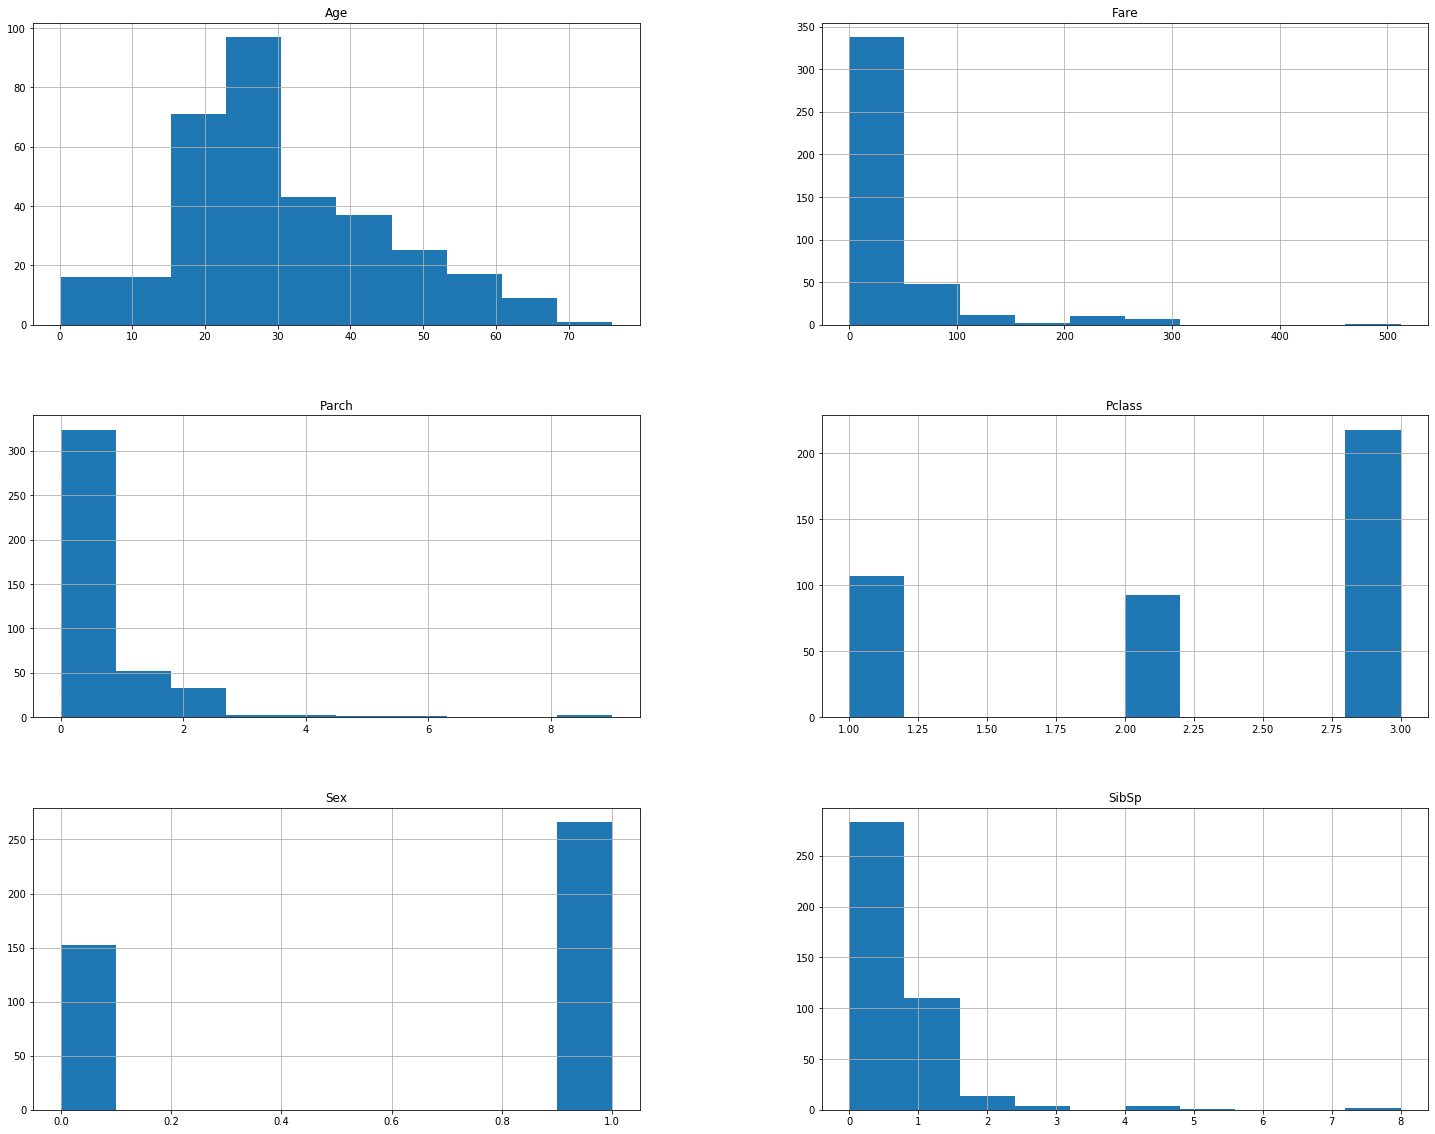

In [99]:
test_df.hist(figsize=(25, 20));

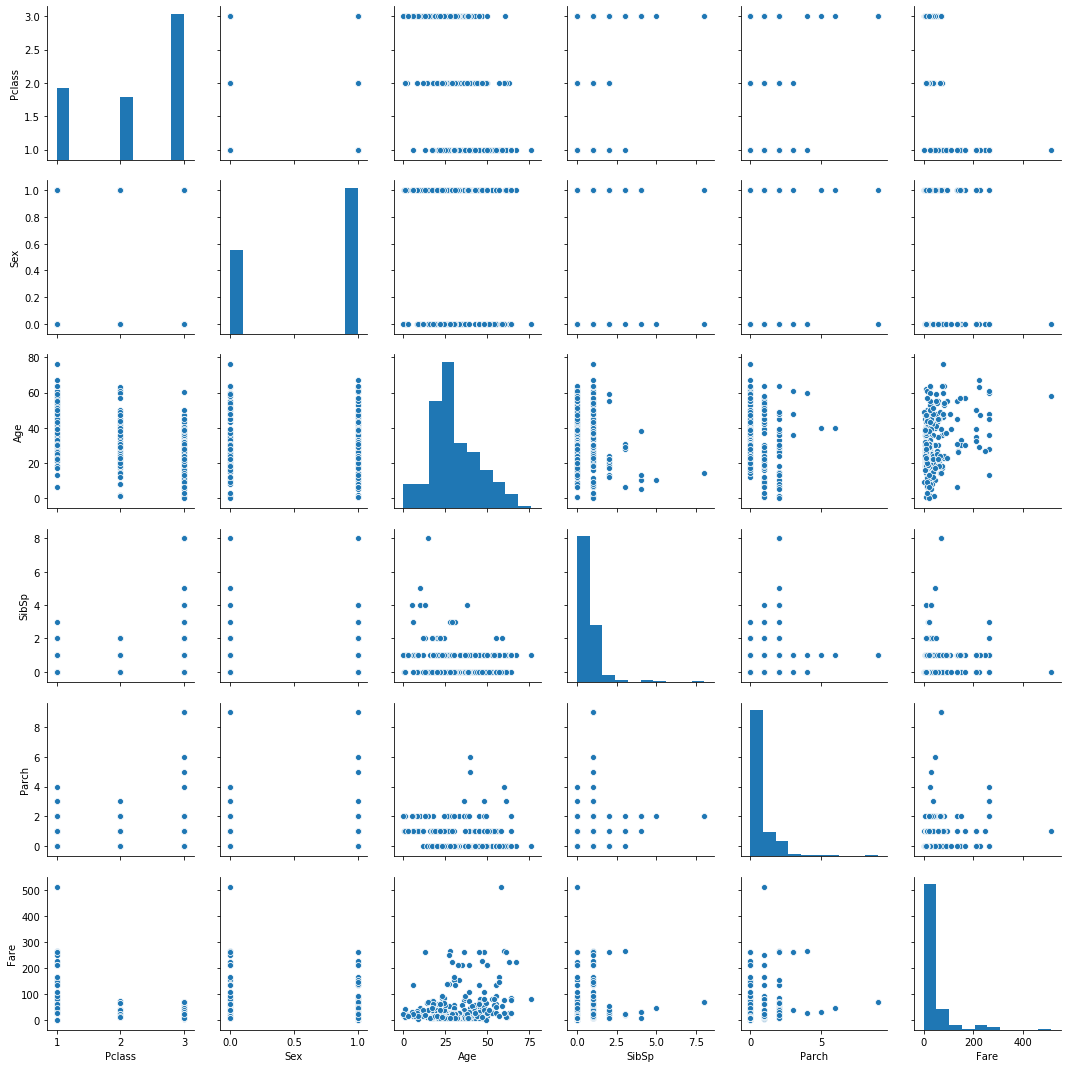

In [100]:
sns.pairplot(data=test_df);

### Class target average probability for Pclass

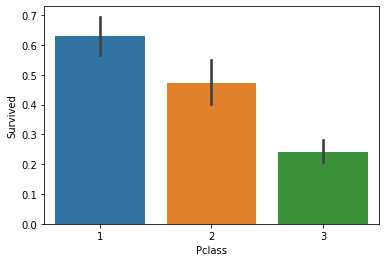

In [101]:
sns.barplot(data=train_df, x='Pclass', y=y);

### Class target average probability for Sex

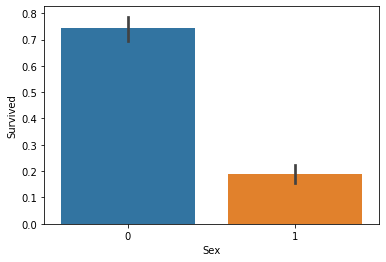

In [102]:
sns.barplot(data=train_df, x='Sex', y=y);

### Class target average probability for SibSp

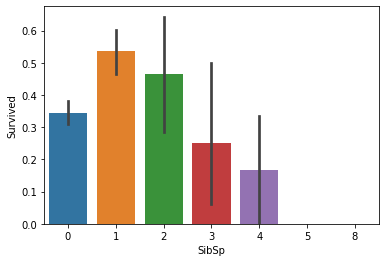

In [103]:
sns.barplot(data=train_df, x='SibSp', y=y);

### Class target average probability for Parch

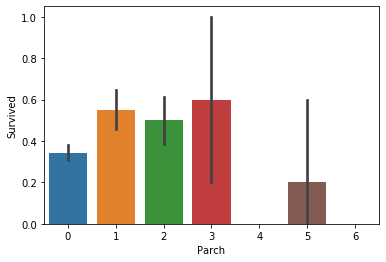

In [104]:
sns.barplot(data=train_df, x='Parch', y=y);

### Class target average probability for FamilySize

In [105]:
for data in (train_df, test_df):
    data['FamilySize'] = data['Parch'] + data['SibSp']

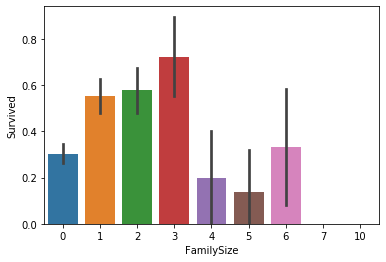

In [106]:
sns.barplot(data=train_df, x='FamilySize', y=y);

### Parch & SibSp will be in percentage

In [107]:
for data in (train_df, test_df):
    data['Parch'] = data['Parch'] / data['FamilySize']
    data['Parch'].fillna(-1, inplace=True)
    data['SibSp'] = data['SibSp'] / data['FamilySize']
    data['SibSp'].fillna(-1, inplace=True)

# Fill NA

In [108]:
for data in (train_df, test_df):
    data['Fare'].fillna(train_df.groupby(['Embarked', 'Pclass'])['Fare'].transform('median'), inplace=True)

for data in (train_df, test_df):
    data['Embarked'].fillna(train_df['Embarked'].mode(), inplace=True)

In [109]:
class AgeFeature(BaseEstimator, TransformerMixin):
    '''AgeFeature - works with df only'''
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        # sex, name
        X['Initial'] = 0
        for i in X:
            X['Initial'] = X.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
        X['Initial'].replace(
            ['Dona','Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
            ['Miss','Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
            inplace=True
        )
        print(X.groupby('Initial')['Age'].median()) # lets check the average age by Initials

        ## Assigning the NaN Values with the Ceil values of the median ages
        X.loc[(X.Age.isnull()) & (X.Initial=='Mr'), 'Age'] = 30
        X.loc[(X.Age.isnull()) & (X.Initial=='Mrs'), 'Age'] = 35
        X.loc[(X.Age.isnull()) & (X.Initial=='Master'), 'Age'] = 3.5
        X.loc[(X.Age.isnull()) & (X.Initial=='Miss'), 'Age'] = 21.5
        X.loc[(X.Age.isnull()) & (X.Initial=='Other'), 'Age'] = 51
        return X['Age'].as_matrix().reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

ager = AgeFeature().fit(train_df)
train_df['Age'] = ager.transform(train_df)
test_df['Age'] = ager.transform(test_df)

Initial
Master     3.5
Miss      21.5
Mr        30.0
Mrs       35.0
Other     51.0
Name: Age, dtype: float64
Initial
Master     7.00
Miss      22.00
Mr        28.75
Mrs       36.50
Other     44.00
Name: Age, dtype: float64


### Is Married flag

In [110]:
for data in (train_df, test_df):
    data['Is_Married'] = 0
    data['Is_Married'].loc[data['Initial'] == 'Mrs'] = 1

## Titanic schema:
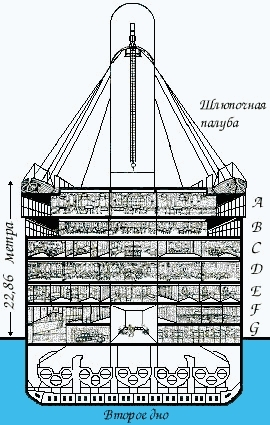

In [111]:
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: str(x)[0]).apply(lambda x: 'n' if x == 'T' else x)
test_df['Cabin'] = test_df['Cabin'].apply(lambda x: str(x)[0]).apply(lambda x: 'n' if x == 'T' else x)
train_df['Cabin'].unique(), test_df['Cabin'].unique()

(array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object),
 array(['n', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object))

### Weight of Evidence Encoding
Weight of Evidence (WoE) is a measure of the “strength” of a grouping technique to separate good and bad. This method was developed primarily to build a predictive model to evaluate the risk of loan default in the credit and financial industry. Weight of evidence (WOE) is a measure of how much the evidence supports or undermines a hypothesis.

In [112]:
woe_encoder = WOEEncoder(cols=['Cabin', 'Embarked', 'Initial'])
woe_encoder.fit(train_df, y)
train_df = woe_encoder.transform(train_df)
test_df = woe_encoder.transform(test_df)

In [113]:
train_df.drop(['Name', 'Ticket'], axis=1, inplace=True)
test_df.drop(['Name', 'Ticket'], axis=1, inplace=True)

## Check columns list

In [114]:
train_df.columns.to_list()

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'Embarked',
 'FamilySize',
 'Initial',
 'Is_Married']

In [115]:
train_df.columns.to_list()

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'Embarked',
 'FamilySize',
 'Initial',
 'Is_Married']

In [116]:
dfs = ps.DataFrameSummary(train_df)
dfs.summary()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,Initial,Is_Married
count,891,891,891,891,891,891,891,891,891,891,891
mean,2.30864,0.647587,29.3919,-0.359468,-0.448613,32.2042,-0.0253696,-0.0117558,0.904602,-0.130444,0.142536
std,0.836071,0.47799,13.2405,0.825955,0.721691,49.6934,0.673585,0.351709,1.61346,1.28419,0.349796
min,1,0,0.42,-1,-1,0,-0.376205,-0.203535,0,-1.15882,0
25%,2,0,21.5,-1,-1,7.9104,-0.376205,-0.203535,0,-1.15882,0
50%,3,1,30,-1,-1,14.4542,-0.376205,-0.203535,0,-1.15882,0
75%,3,1,35,0.5,0,31,-0.376205,0.0338793,1,1.32854,0
max,3,1,80,1,1,512.329,1.53197,1.56971,10,1.80023,1
counts,891,891,891,891,891,891,891,891,891,891,891
uniques,3,2,90,15,15,248,8,4,9,5,2


In [117]:
dfs = ps.DataFrameSummary(test_df)
dfs.summary()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,Initial,Is_Married
count,418,418,418,418,418,418,418,418,418,418,418
mean,2.26555,0.636364,29.7775,-0.362224,-0.453566,35.5612,-0.0565724,0.0390832,0.839713,-0.0755361,0.172249
std,0.841838,0.481622,13.0221,0.827274,0.719811,55.8568,0.633098,0.373821,1.51907,1.30682,0.378049
min,1,0,0.17,-1,-1,0,-0.376205,-0.203535,0,-1.15882,0
25%,1,0,21.625,-1,-1,7.8958,-0.376205,-0.203535,0,-1.15882,0
50%,3,1,30,-1,-1,14.4542,-0.376205,-0.203535,0,-1.15882,0
75%,3,1,35.75,0.5,0,31.4719,-0.376205,0.0338793,1,1.32854,0
max,3,1,76,1,1,512.329,1.53197,0.683655,10,1.80023,1
counts,418,418,418,418,418,418,418,418,418,418,418
uniques,3,2,81,15,15,169,8,3,9,5,2


# Let's look on final dataset in 2d dimension by tSNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The technique can be implemented via Barnes-Hut approximations, allowing it to be applied on large real-world datasets. 

In [118]:
scaler = StandardScaler().fit(train_df)
scaled_train_df = scaler.transform(train_df)
scaled_test_df = scaler.transform(test_df)

In [119]:
tsne = TSNE(perplexity=30)

train_tsne_transformed = tsne.fit_transform(scaled_train_df)
test_tsne_transformed = tsne.fit_transform(scaled_test_df)

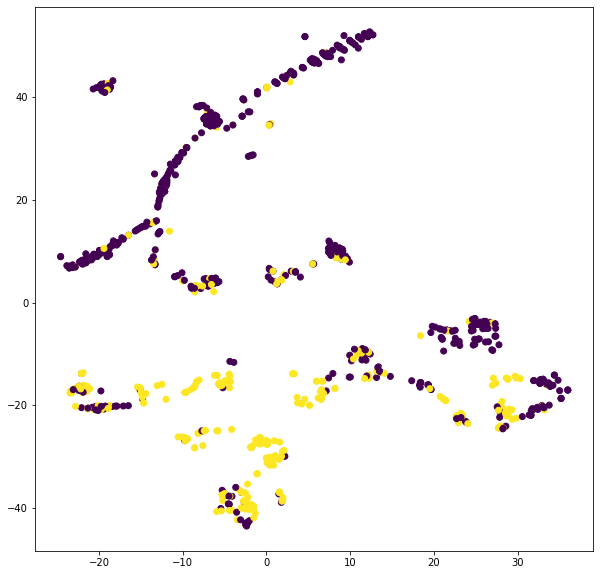

In [120]:
plt.figure(figsize=(10, 10))
plt.scatter(train_tsne_transformed[:, 0], train_tsne_transformed[:, 1], c=y);

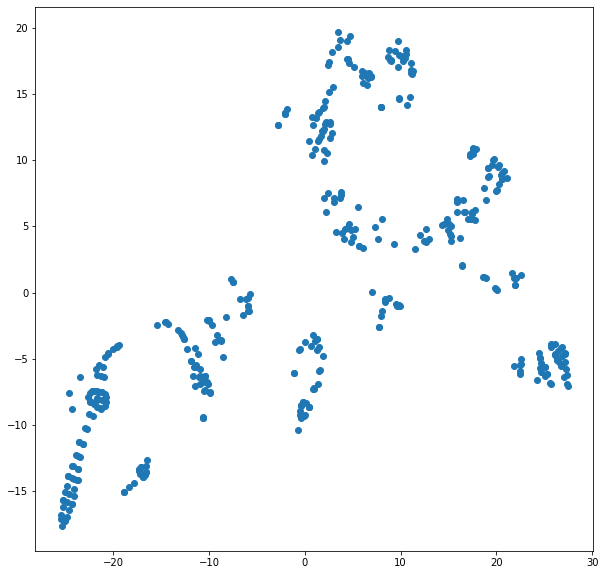

In [121]:
plt.figure(figsize=(10, 10))
plt.scatter(test_tsne_transformed[:, 0], test_tsne_transformed[:, 1]);

#### I think, trees will be the best algorithm.

In [122]:
# Чем больше P, тем меньше мы хотим штрафовать за разницу между train  и test
p = 0.7
# k - количество итераций
k = 250
cat=[]
models = dict()
trains = []
preds = []
folds = []
valid_scores =dict()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

for num, spl in enumerate(skf.split(train_df, y)):
    train_index, val_index = spl[0], spl[1]
    x_train_1, x_valid_1 = train_df.iloc[train_index, :], train_df.iloc[val_index, :]
    y_train_1, y_valid_1 = y.iloc[train_index], y.iloc[val_index]
    
    print('fold: ', num+1)
    
    def score(params):
        w=[]
        best_iter = []
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=77)

        for train_index_2, val_index_2 in skf.split(x_train_1, y_train_1):
            x_train_2, x_valid_2 = x_train_1.iloc[train_index_2, :], x_train_1.iloc[val_index_2, :]
            y_train_2, y_valid_2 = y_train_1.iloc[train_index_2], y_train_1.iloc[val_index_2]
            train_data = lgb.Dataset(x_train_2, label=y_train_2,)
            val_data = lgb.Dataset(x_valid_2, label=y_valid_2, reference=train_data)
            gbm = lgb.train(params, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'],
                            num_boost_round = 5800, verbose_eval = False,)
            w.append([gbm.best_score['train']['auc'], gbm.best_score['val']['auc']])
            best_iter.append(gbm.best_iteration)
        nrounds = np.mean(best_iter)
        res = list(np.mean(w, axis=0))
        return {'loss': -res[1]+np.power(np.square(res[0]-res[1]), p), 'status': STATUS_OK, 
                'mean_auc_train': res[0], 'mean_auc_test': res[1], 'best_iter': int(nrounds)}

    def optimize(trials):
        space = {
        #'max_depth': hp.choice('max_depth', [-1, 6, 7]),
        'max_depth': -1,
        'max_bin': scope.int(hp.uniform('max_bin', 3, 200)),
        'num_leaves': scope.int(hp.uniform('num_leaves', 4, 16)),
        'min_data_in_leaf': scope.int(hp.uniform('min_data_in_leaf', 2, 75)),
        'lambda_l1': hp.quniform('lambda_l1', 0, 6.5, 0.25),
        'lambda_l2': hp.quniform('lambda_l2', 0, 10.5, 0.25),
        'learning_rate': hp.quniform('learning_rate', 0.01 , 0.05, 0.005),
        'min_child_weight': hp.quniform('min_child_weight', 0.05, 25.95, 0.05),
        'feature_fraction': hp.quniform('feature_fraction', 0.4, 0.8, 0.1),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.45, 0.95, 0.05),
        'metric': ('auc',),
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'nthread': 8,
        'early_stopping_rounds': 10,
        'silent':1,
        }
        best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=k)
        #print(best)
        
    trials = Trials()
    optimize(trials)
    params_for = trials.best_trial['misc']['vals']
    params_for['num_leaves'] = int(params_for['num_leaves'][0])
    params_for['max_bin'] = int(params_for['max_bin'][0])
    params_for['min_data_in_leaf'] = int(params_for['min_data_in_leaf'][0])
    params_for['objective'] = 'binary'
    params_for['metric'] = {'auc'}
    
    train_data = lgb.Dataset(x_train_1, label=y_train_1)
    val_data = lgb.Dataset(x_valid_1, label=y_valid_1, reference=train_data)
    gbm_main = lgb.train(params_for, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'],
                         num_boost_round = 10000, verbose_eval = 100, early_stopping_rounds = 20)
    trains.append(gbm_main.predict(train_df))
    preds.append(gbm_main.predict(test_df))
    folds.append(gbm_main.best_score['val']['auc'])
    print('best score: ', gbm_main.best_score['val']['auc'])
    print()
    valid_scores[num] = gbm_main.best_score['val']['auc']
    models['lgb_fold'+str(num+1)] = gbm_main

fold:  1
100%|██████| 250/250 [00:27<00:00,  9.21trial/s, best loss: -0.868316398846999]
Training until validation scores don't improve for 20 rounds.
[100]	train's auc: 0.90533	val's auc: 0.874545
Early stopping, best iteration is:
[113]	train's auc: 0.906827	val's auc: 0.878442
best score:  0.8784415584415585

fold:  2
100%|█████| 250/250 [00:27<00:00,  9.07trial/s, best loss: -0.8793264419105706]
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[47]	train's auc: 0.88598	val's auc: 0.833247
best score:  0.8332467532467532

fold:  3
100%|██████| 250/250 [00:28<00:00,  8.75trial/s, best loss: -0.868245483698657]
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[22]	train's auc: 0.890097	val's auc: 0.900535
best score:  0.9005347593582887

fold:  4
100%|█████| 250/250 [00:27<00:00,  9.15trial/s, best loss: -0.8764180142003668]
Training until validation scores don't improve for 20 rounds.
[100

In [123]:
model = LogisticRegression(penalty='l1')
#pd.Series(np.mean(np.array(preds), axis=0))
model.fit(pd.DataFrame(np.array(trains)).T, y)
target = model.predict(pd.DataFrame(np.array(preds)).T)

In [124]:
sub_df['Survived'] = target

In [125]:
sub_df.to_csv("submission.csv", index=False)